##**Group4**
Nguyễn Nhật Minh - 23122010

Nguyễn Gia Bảo - 23122015

Nguyễn Văn Khoa - 23122016

Bùi Anh Quân - 23122017

**I. TreeBoosting cơ bản**

Sử dụng class DecisionTreeRegressor của scikit-learn


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils import check_array, check_X_y

class SimpleGBDTRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees_ = []
        self.init_pred_ = None

    def fit(self, X, y):
        # Validate inputs
        X, y = check_X_y(X, y)
        y = y.astype(float)
        # Initialize prediction
        self.init_pred_ = np.mean(y)
        y_pred = np.full_like(y, self.init_pred_, dtype=float)

        # Fit each tree on residuals
        for _ in range(self.n_estimators):
            residual = y - y_pred
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X, residual)
            self.trees_.append(tree)
            y_pred += self.learning_rate * tree.predict(X)
        return self

    def predict(self, X):
        X = check_array(X)
        y_pred = np.full(X.shape[0], self.init_pred_, dtype=float)
        for tree in self.trees_:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


class SimpleGBDTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees_ = []
        self.init_logodds_ = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        # Convert y to {0,1}
        classes = np.unique(y)
        if set(classes) != {0, 1}:
            raise ValueError('y must be binary labels 0 and 1')
        # Initialize log-odds
        p = np.clip(np.mean(y), 1e-15, 1 - 1e-15)
        self.init_logodds_ = np.log(p / (1 - p))
        # Initial prediction in logit space
        y_pred = np.full_like(y, self.init_logodds_, dtype=float)

        # Fit trees on negative gradient of log-loss
        for _ in range(self.n_estimators):
            prob = 1 / (1 + np.exp(-y_pred))
            gradient = y - prob  # negative gradient of log-loss
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X, gradient)
            self.trees_.append(tree)
            y_pred += self.learning_rate * tree.predict(X)
        return self

    def predict_proba(self, X):
        X = check_array(X)
        y_pred = np.full(X.shape[0], self.init_logodds_, dtype=float)
        for tree in self.trees_:
            y_pred += self.learning_rate * tree.predict(X)
        prob = 1 / (1 + np.exp(-y_pred))
        return np.vstack([1 - prob, prob]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba > 0.5).astype(int)

**I.1 Dự đoán giá xe cũ (bài toán hồi quy)**

In [2]:
import re
import pandas as pd
def pre_processing(data):
    categorical_cols = ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']
    mappings = {}

    for col in categorical_cols:
        data[col] = data[col].fillna('Unknown').astype(str)
        unique_vals = sorted(data[col].unique())
        mappings[col] = {val: idx for idx, val in enumerate(unique_vals)}
        data[col] = data[col].map(mappings[col])

    special_cols = ['Max Power', 'Max Torque']
    for col in special_cols:
        data[col] = data[col].apply(lambda x: re.findall(r'^\d+\.?\d*', str(x))[0] if pd.notna(x) and re.findall(r'^\d+\.?\d*', str(x)) else '0')
        data[col] = data[col].astype(float)

    numerical_cols = ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
    for col in numerical_cols:
        data[col] = data[col].astype(float)
    #xử lí các cột Engine, age (=2024 - Year),seating Capacity và fuel tank capacity
    data['Fuel Tank Capacity'].fillna(data['Fuel Tank Capacity'].mean(), inplace=True)
    data['Engine'] = data['Engine'].str.split(' ', expand = True)[0].astype(float)
    data['Engine'].fillna(data['Engine'].mean(), inplace=True)
    data['age'] = 2024 - data['Year']
    data['Seating Capacity'].bfill(inplace=True)
    #Xử lí cột Make-Num (bằng `xếp hạng` thứ tự giá trung bình các `hãng xe` rồi gán cho từng cột tương ứng với các hãng)
    #print(data['Make'])
    make_rank = data[['Make', 'Price']].groupby('Make').mean().rank()
    data['Make-Num'] = data['Make'].map(make_rank['Price'])
    data['Make-Num']
    #print(make_rank)
    # data['Make-Num'] = 0
    # for make in make_rank['Make']:
    #     data.loc[data['Make'] == make,'Make-Num'] = make_rank.loc[make]
    # data.info()
data = pd.read_csv("train.csv")
print(data.head())
pre_processing(data)

            Make                            Model     Price  Year  Kilometer  \
0            BMW                    3-Series 320d    800000  2012      75576   
1            BMW               X1 sDrive20d xLine   2199000  2016      77000   
2       Mahindra                   XUV500 W4 1.99    800000  2017     112000   
3  Mercedes-Benz                  GLS 400d 4MATIC  12900000  2021       3000   
4         Toyota  Fortuner 2.8 4x2 AT [2016-2020]   3499000  2019      73000   

  Fuel Type Transmission     Location   Color   Owner Seller Type   Engine  \
0    Diesel    Automatic       Mumbai   White  Second  Individual      NaN   
1    Diesel    Automatic        Surat   Black   First  Individual  1995 cc   
2    Diesel       Manual  Muzaffurpur  Silver   First  Individual  1997 cc   
3    Diesel    Automatic        Delhi   White   First  Individual  2925 cc   
4    Diesel    Automatic       Mumbai   White   First  Individual  2755 cc   

            Max Power         Max Torque Drivetrai

C:\Users\Admin\AppData\Local\Temp\ipykernel_12680\3245499715.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fuel Tank Capacity'].fillna(data['Fuel Tank Capacity'].mean(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12680\3245499715.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

--- Đánh giá mô hình (tập train) ---

Mean Squared Error (MSE): 20900082861.36
Coefficient of Determination (R²): 0.996


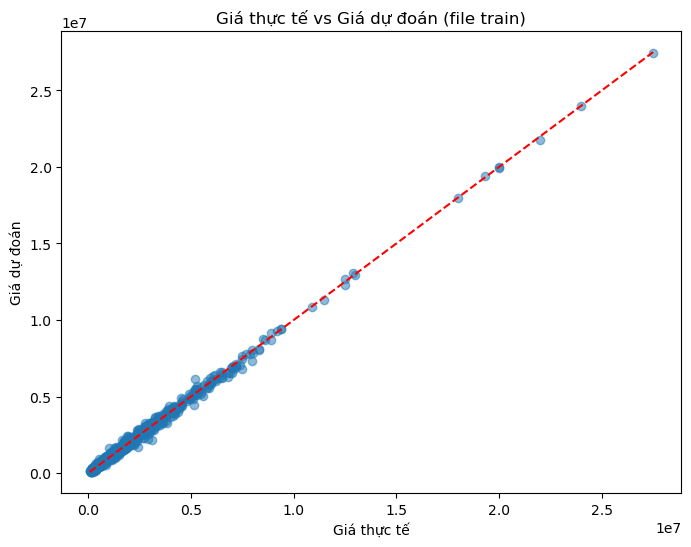

--- Đánh giá mô hình (tập test) ---

Mean Squared Error (MSE): 557862079994.05
Coefficient of Determination (R²): 0.885


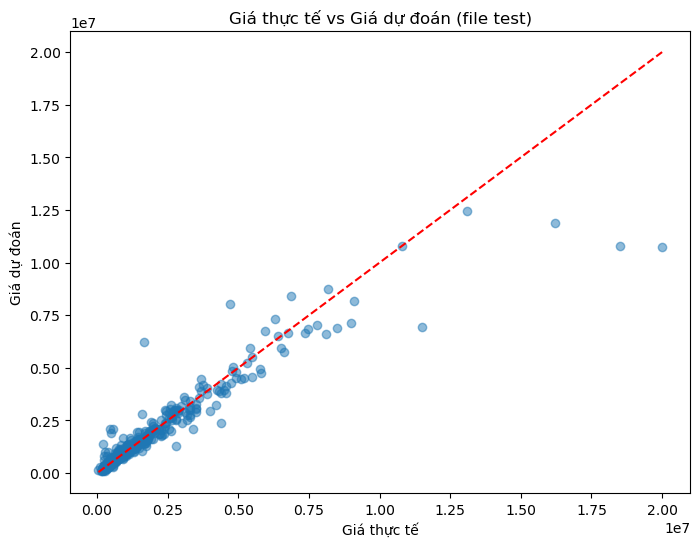

In [3]:
y = data['Price'].fillna(0)
X = data.drop('Price', axis=1)
X = X.replace([np.inf, -np.inf], 0).fillna(0)
# Loại cột có tương quan cao (> 0.9)
correlation_matrix = X.corr()
high_corr = set()
corr_threshold = 0.9
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr.add(colname)
if len(high_corr) > 0:
    X = X.drop(columns=high_corr)
#huấn luyện mô hình
SimpleTB_regression = SimpleGBDTRegressor(n_estimators=300)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
SimpleTB_regression.fit(X_train, y_train)
#dự đoán (file train)
y_pred = SimpleTB_regression.predict(X_train)
y_vec = y_train.values
mse = np.mean((y_vec - y_pred) ** 2)
rss = np.sum((y_vec - y_pred) ** 2)  # Residual Sum of Squares
tss = np.sum((y_vec - np.mean(y_vec)) ** 2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)
print("--- Đánh giá mô hình (tập train) ---")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.3f}")
actual_prices = y_vec
predicted_prices = y_pred
min_val = min(np.min(actual_prices), np.min(predicted_prices))
max_val = max(np.max(actual_prices), np.max(predicted_prices))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Vẽ đường y = x
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Giá thực tế vs Giá dự đoán (file train)')
plt.show()
#dự đoán (file test)
y_pred = SimpleTB_regression.predict(X_test)
y_vec = y_test.values
mse = np.mean((y_vec - y_pred) ** 2)
rss = np.sum((y_vec - y_pred) ** 2)  # Residual Sum of Squares
tss = np.sum((y_vec - np.mean(y_vec)) ** 2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)
print("--- Đánh giá mô hình (tập test) ---")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.3f}")
actual_prices = y_vec
predicted_prices = y_pred
min_val = min(np.min(actual_prices), np.min(predicted_prices))
max_val = max(np.max(actual_prices), np.max(predicted_prices))

plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Vẽ đường y = x
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Giá thực tế vs Giá dự đoán (file test)')
plt.show()

**I.1 Dự đoán ung thư hay không (bài toán phân loại)**

In [4]:
import warnings

warnings.filterwarnings('ignore')

data = 'ABIDE2(updated).csv'

df = pd.read_csv(data)
df['num'] = (df['group'] == 'Cancer').astype(int)
X = df.drop(['site', 'age', 'group', 'num'], axis=1)

y = df['num']
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chuẩn hóa dữ liệu
X_std = StandardScaler().fit_transform(X)

# Khởi tạo và fit mô hình PCA của scikit-learn
sklearn_pca = PCA(n_components=190)
sklearn_pca.fit(X_std)
X_sklearn = sklearn_pca.transform(X_std)
X_sklearn.shape

(1004, 190)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_sklearn, y, test_size = 0.3, random_state = 0)
SimpleTB_Class = SimpleGBDTClassifier(max_depth=3, min_samples_leaf = 5, learning_rate=0.05, n_estimators=300)
SimpleTB_Class.fit(X_train, y_train)

SimpleGBDTClassifier(learning_rate=0.05, min_samples_leaf=5, n_estimators=300)

In [6]:
y_pred = SimpleTB_Class.predict(X_train)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Train file: ')
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
print('XGBoost model precision score: {0:0.4f}'. format(precision_score(y_train, y_pred)))
print('XGBoost model recall score: {0:0.4f}'. format(recall_score(y_train, y_pred)))
print('XGBoost model f1-score score: {0:0.4f}'. format(f1_score(y_train, y_pred)))

Train file: 
XGBoost model accuracy score: 0.9701
XGBoost model precision score: 1.0000
XGBoost model recall score: 0.9340
XGBoost model f1-score score: 0.9659


In [8]:
y_pred = SimpleTB_Class.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Validation file: ')
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('XGBoost model precision score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('XGBoost model recall score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('XGBoost model f1-score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

Validation file: 
XGBoost model accuracy score: 0.5762
XGBoost model precision score: 0.5739
XGBoost model recall score: 0.4552
XGBoost model f1-score score: 0.5077
